# Example 3
In this example, we detect core-periphery structure in the political blog network. 

# Packages

In [1]:
%load_ext autoreload
%autoreload 2
import sys

import cpnet
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

# import utils
from scipy import sparse

# Data

Source: Adamic, L. A., & Glance, N. (2005). The political blogosphere and the 2004 U.S. election. Proceedings of the 3rd International Workshop on Link Discovery - LinkKDD ’05, 36–43. https://doi.org/10.1145/1134271.1134277

In [2]:
# Load the blog net
edges = pd.read_csv(
    "https://raw.githubusercontent.com/skojaku/core-periphery-detection/add-notebook/data/out.moreno_blogs_blogs?token=AEJQ7B2R37SGEAUYDQBRALK7O2JYW"
)
node_table = pd.read_csv(
    "https://raw.githubusercontent.com/skojaku/core-periphery-detection/add-notebook/data/ent.moreno_blogs_blogs.blog.orientation?token=AEJQ7B6BERYDDW3THRAZFEK7O2J3G",
    sep=",",
    header=None,
    names=["class"],
)
N = np.max(edges.max().values) + 1
net = sparse.csc_matrix(
    (np.ones(edges.shape[0]), (edges.source - 1, edges.target - 1)), shape=(N, N)
)

# Extract the largest connected component
G = nx.from_scipy_sparse_matrix(net)
node_set = sorted(nx.connected_components(G), key=len, reverse=True)[0]
G = G.subgraph(node_set)
node_table = node_table.iloc[np.array(list(node_set)), :]

# Convert to the adjacency matrix
net = nx.adjacency_matrix(G)
net = net + net.T
net.data = np.ones_like(net.data)

node_table["id"] = np.arange(net.shape[0])

In [3]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1222
Number of edges: 16717
Average degree:  27.3601


# Detect core-periphery structure

In [4]:
# Detect core-periphery structure
kmconfig = cpnet.KM_config()  # Call the BE algorithm
kmconfig.detect(G)  # Detect core-periphery structures
c = kmconfig.get_pair_id()  # Get the group membership of nodes
x = kmconfig.get_coreness()  # Get the coreness of nodes

# Statistical test

In [5]:
sig_c, sig_x, significant, p_values = cpnet.qstest(
    c,
    x,
    G,
    kmconfig,
    significance_level=0.05,
    num_of_thread=16,
)

100%|██████████| 300/300 [02:43<00:00,  1.83it/s]


# Visualization

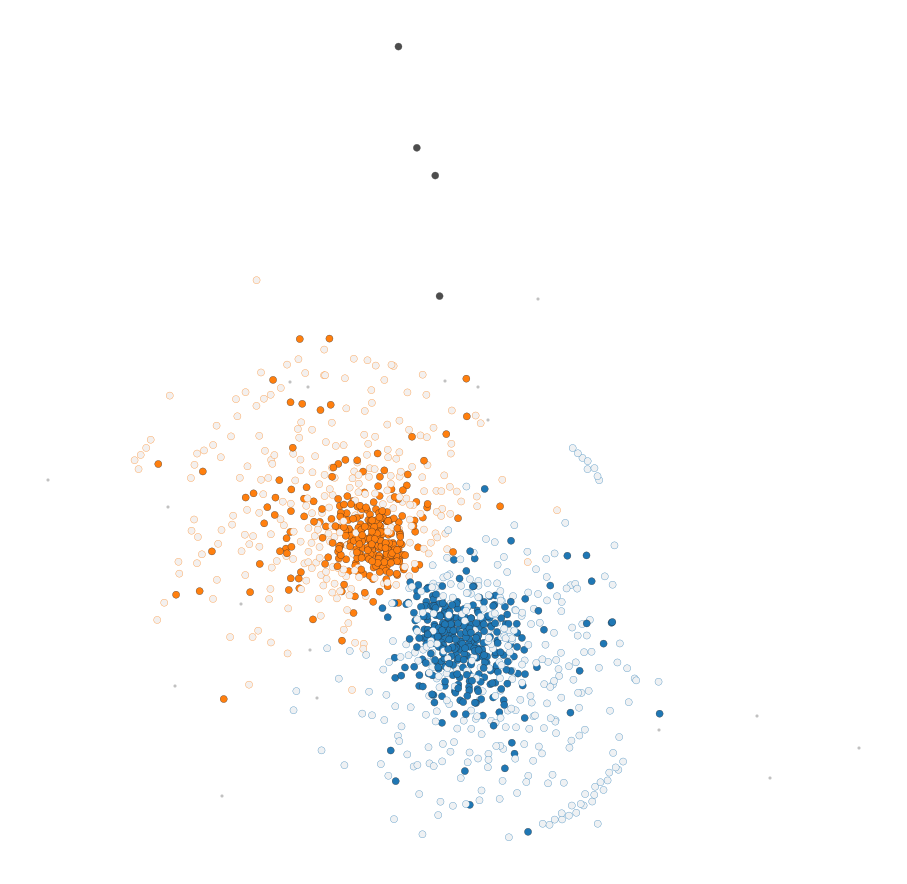

In [6]:
fig = plt.figure(figsize=(16, 16))
ax = plt.gca()

draw_nodes_kwd = {"node_size": 50, "linewidths": 0.3}
ax, pos = cpnet.draw(
    G,
    sig_c,
    sig_x,
    ax,
    max_colored_group_num=2,
    draw_nodes_kwd=draw_nodes_kwd,
    draw_edge=False,
)